In [143]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import rsa

## Encoding and Decoding Functions

In [144]:
def audio_from_wav(filename, save_mono=False):
    fs, data = wavfile.read(filename)
    audio = (data[:,0] + data[:,1]) // 2
    if (save_mono):
        data[:,0] = audio
        data[:,1] = audio
        filename = filename.split('.')[0] + '_mono.wav'
        wavfile.write(filename, fs, data)
    return fs, audio

def audio_to_wav(audio, filename, fs, N_original):
    data = np.zeros((N_original, 2)).astype(np.int16)
    data[:,0] = audio[0:N_original]
    data[:,1] = audio[0:N_original]
    wavfile.write(filename, fs, data)

def pad_audio(audio, fs, df):
    N = len(audio)
    N_min = fs/df
    N_req = int((N // N_min + 1) * N_min - N)
    pad = np.linspace(0, 0, N_req)
    audio = np.concatenate((audio, pad))
    return audio

def remove_low_frequencies(audio, fs, f_max):
    audio_fft = np.fft.rfft(audio)
    audio_fft[0:len(audio)*f_max//fs] = 0
    audio = np.real(np.fft.irfft(audio_fft))
    return audio

def add_data(audio, data, ampl, fs, df, f_min):
    f_min = max(f_min, df)
    
    f_data = np.linspace(f_min, f_min + (len(data)-1) * df, len(data))
    f_audio = np.fft.rfftfreq(len(audio), 1/fs)
    audio_fft = np.fft.rfft(audio)

    f_d = 0
    for f in range(len(f_audio)):
        if (f_data[f_d] <= f_audio[f]):
            audio_fft[f] = ampl * data[f_d]
            f_d += 1
            if f_d == len(f_data):
                break

    audio = np.real(np.fft.irfft(audio_fft))
    return audio

def recover_data(audio, data_ampl, data_len, fs, df, f_min):
    data = np.zeros(data_len)

    f_data = np.linspace(f_min, f_min + (len(data)-1) * df, len(data))
    f_audio = np.fft.rfftfreq(len(audio), 1/fs)
    audio_fft = np.fft.rfft(audio)

    f_d = 0
    for f in range(len(f_audio)):
        if (f_data[f_d] <= f_audio[f]):
            if (audio_fft[f] > data_ampl/2):
                data[f_d] = 1
            f_d += 1
            if f_d == len(f_data):
                break
    return data

## Encryption Functions

In [145]:
def create_keys(length):
    public_key, private_key = rsa.newkeys(length)

    with open('public_key.pem', 'wb') as f:
        f.write(public_key.save_pkcs1())
    
    with open('private_key.pem', 'wb') as f:
        f.write(private_key.save_pkcs1())
        
    return public_key, private_key

def encrypt_data(message, private_key):
    return rsa.sign(message.encode(), private_key, 'SHA-1')

def check_data(message, sign_message , public_key):
    try:
        rsa.verify(message.encode(), sign_message, public_key)
        return True
    except:
        return False
    

def extract_audio_signature(audio_name):
    fs, audio = audio_from_wav(audio_name)

    # start inputs
    f_start = 100
    f_end = 4100
    df = 1
    section_size = 100

    # arrays
    averages = np.zeros((f_end-f_start)//section_size)
    byte_averages = np.zeros(len(averages)//8)
    output = np.zeros(len(averages))

    # fourier transform audio
    audio = pad_audio(audio, fs, df)
    f_full = np.fft.rfftfreq(len(audio), 1/fs)
    audio_fft = np.fft.rfft(audio)

    # calculate average for all
    total, count = 0, 0
    section = 0
    section_start = f_start + section * section_size
    section_end = section_start + section_size
    for i in range(len(f_full)):
        if (f_full[i] > section_start and f_full[i] <= section_end):
            total += np.abs(audio_fft[i])
            count+=1
        if (f_full[i] >= section_end):
            averages[section] = total / count
            count = 0
            total = 0

            section += 1
            section_start = f_start + section * section_size
            section_end = section_start + section_size

            if (section == len(averages)):
                break

    # calculate average for each byte
    for i in range(len(averages)):
        byte_averages[i//8] += averages[i]
    byte_averages = byte_averages / 8

    # compare averages
    for i in range(len(averages)):
        output[i] = (averages[i] > byte_averages[i//8])

    return output.astype(int)


def convert_bit_array_to_string(bit_array):
    print(type(bit_array[0]))
    binary_string = ''.join(str(bit) for bit in bit_array)
    ascii_chars = ["0" + binary_string[i+1:i+8] for i in range(0, len(binary_string), 8)]
    print(ascii_chars)
    string = ''.join(chr(int(char, 2)) for char in ascii_chars)
    return string

def bytes_to_binary(bytes_obj):
    return ''.join(format(byte, '08b') for byte in bytes_obj)

def binary_to_bytes(binary_str):
    return bytes(int(binary_str[i:i+8], 2) for i in range(0, len(binary_str), 8))


def get_data(audio_name,private_key):
    message = convert_bit_array_to_string(extract_audio_signature(audio_name))
    
    sign_message = encrypt_data(message, private_key)
    bin_sign_message=bytes_to_binary(sign_message)    
    bin_data = [int(bit) for bit in bin_sign_message]
    return bin_data


def check_watermark(audio_name, bin_data_array , public_key):
    message = convert_bit_array_to_string(extract_audio_signature(audio_name))
    bin_data = ''.join(str(bit) for bit in bin_data_array)
    sign_message = binary_to_bytes(bin_data)
    return check_data(message, sign_message, public_key)
    
public_key, private_key = create_keys(365)

watermark = get_data('AudioFiles/bumblebee/bumblebee_small.wav',private_key)

print(len(watermark))

print(check_watermark('AudioFiles/bumblebee/bumblebee_small_with_data.wav', watermark, public_key))


<class 'numpy.int32'>
['01101000', '01001000', '01100100', '01110000', '00000001']
368
<class 'numpy.int32'>
['01101000', '01001000', '01100100', '01010000', '01000001']
False


## Helper Functions

In [146]:
def plot_fft(audio, fs, f_max = 250):
    f_full = np.fft.rfftfreq(len(audio), 1/fs)
    audio_fft = np.fft.rfft(audio)
    plt.figure()
    plt.plot(f_full, np.abs(audio_fft))
    plt.xlim([0, f_max])
    plt.ylim([0, 1.5e7])
    plt.title('Song fft')

## Implentation

In [147]:
DELTA_FREQUENCIES = 0.2 # Hz
LOWEST_FREQUENCY = 1 # Hz
DATA_LENGTH = 368
BINARY_AMPLITUDES = 1e7

def encrypt_audio(filename):
    # Keys and data
    public_key, private_key = create_keys(365);
    data = get_data(filename, private_key)
    print(data)
    print(''.join(str(bit) for bit in data))
    # Audio from file
    fs, audio = audio_from_wav(filename, True)
    N_original = len(audio)
    # plot_fft(audio, fs)

    # Add data to audio
    audio = pad_audio(audio, fs, DELTA_FREQUENCIES)
    audio = remove_low_frequencies(audio, fs, 100)
    # plot_fft(audio, fs)
    audio = add_data(audio, data, BINARY_AMPLITUDES, fs, DELTA_FREQUENCIES, LOWEST_FREQUENCY)
    # plot_fft(audio, fs)
    plot_fft(audio, fs)

    # Save audio to file
    audio_to_wav(audio, filename.split('.')[0] + '_with_data.wav', fs, N_original)
    return public_key, private_key

    

def check_audio(filename, public_key):
    fs, audio = audio_from_wav(filename)
    audio = pad_audio(audio, fs, DELTA_FREQUENCIES)
    plot_fft(audio, fs)

    data_r = recover_data(audio, BINARY_AMPLITUDES, DATA_LENGTH, fs, DELTA_FREQUENCIES, LOWEST_FREQUENCY).astype(int)
    
    #print(data_r)
    print(''.join(str(bit) for bit in data_r))

    check = check_watermark(filename,data_r,public_key)
    return check


<class 'numpy.int32'>
['01101000', '01001000', '01100100', '01110000', '00000001']
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1

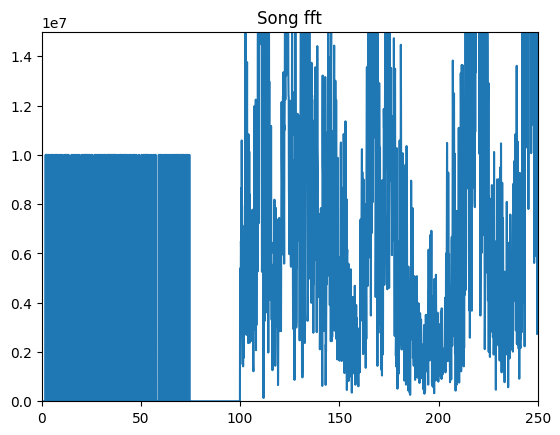

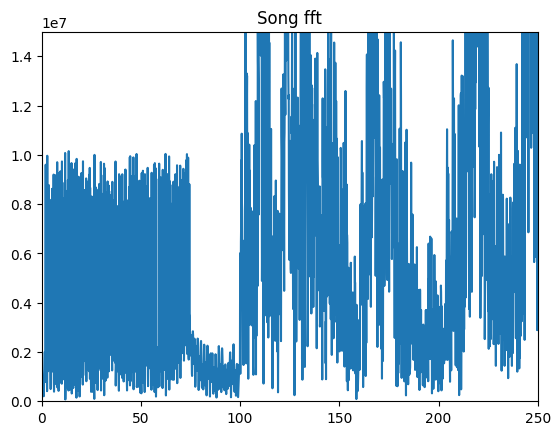

In [148]:
public_key, _ = encrypt_audio('AudioFiles/bumblebee/bumblebee_small.wav')
print(check_audio('AudioFiles/bumblebee/bumblebee_small_with_data.wav', public_key))
